# Визуализация временного ряда.

In [27]:
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import numpy as np
import plotly.io as pio
import statsmodels.api as smapi
from sklearn.metrics import r2_score
pio.renderers.default='svg'

In [11]:
import os

os.chdir('/Users/adelbaymashev/Downloads')

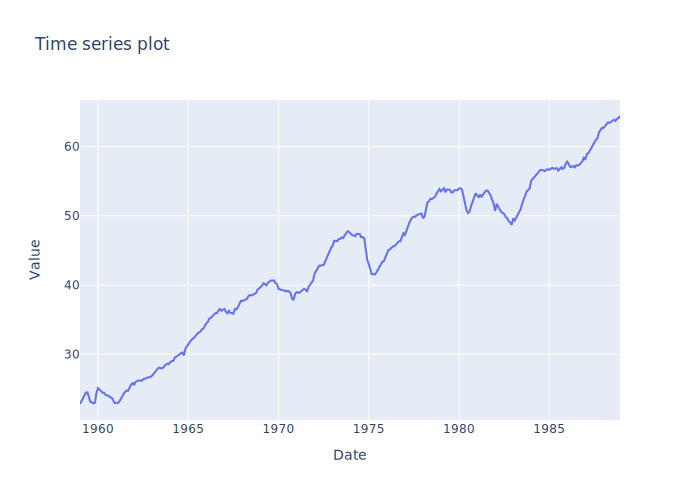

In [12]:
import plotly.express as px

data = pd.read_csv('training.csv')
fig = px.line(data, x="Date", y="Value", render_mode="svg", title = 'Time series plot')
fig.show()

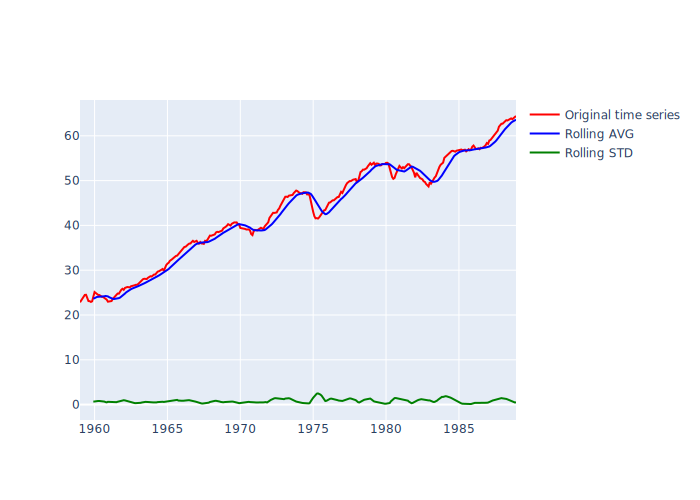

In [13]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
        x=data.Date,
        y=data.Value,
        mode="lines",
        line=go.scatter.Line(color="red"),
        showlegend=True,
        name = 'Original time series'))

fig.add_trace(go.Scatter(
        x=data.join(data['Value'].rolling(12).mean(), rsuffix="_avg").Date,
        y=data.join(data['Value'].rolling(12).mean(), rsuffix="_avg").Value_avg,
        mode="lines",
        line=go.scatter.Line(color="blue"),
        showlegend=True,
        name = 'Rolling AVG'))

fig.add_trace(go.Scatter(
        x=data.join(data['Value'].rolling(12).std(), rsuffix="_std").Date,
        y=data.join(data['Value'].rolling(12).std(), rsuffix="_std").Value_std,
        mode="lines",
        line=go.scatter.Line(color="green"),
        showlegend=True,
        name = 'Rolling STD'))

fig.show()

#### Как видим из графика, дисперсия из года в год остается на одном уровне, поэтому ряд обладает свойством гомоскедастичности.

#  Тест Дики-Фуллера.

In [14]:
def dfTest(ts, isPrint=True):
    test = sm.tsa.adfuller(ts)
    if isPrint:
        print('Значение статистики теста Дики-Фуллера: ', test[0]) 
        print('p-значение: ', test[1]) 
        print('Критические значения: ', test[4])  
    if test[0] > test[4]['5%']: 
        if isPrint:
            print('Есть единичные корни, ряд нестационарен')
        return False
    else:
        if isPrint:
            print('Единичных корней нет, ряд стационарен')
        return True
    return False

ts = pd.Series(np.asarray(data['Value'], dtype=np.float64), index=data['Date'])
ts.dropna(inplace=True)
dfTest(ts)

Значение статистики теста Дики-Фуллера:  -0.2533911799284588
p-значение:  0.9318510422993471
Критические значения:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Есть единичные корни, ряд нестационарен


False

# Разложение ряда на тренд, сезональность, остаток

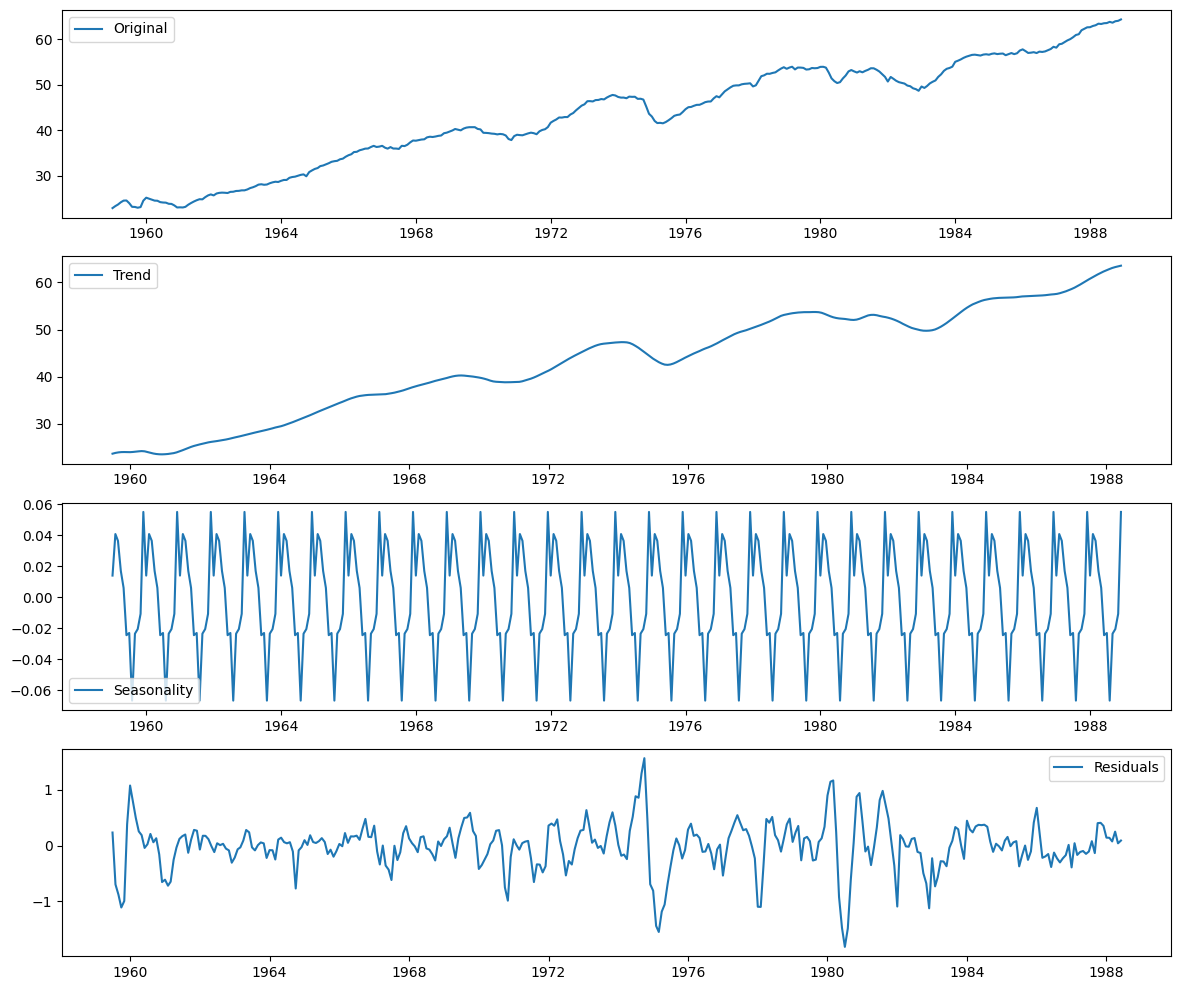

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

ts.index = pd.to_datetime(ts.index)

decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

## Проверка на стационарность тренда

In [16]:
ts_t = trend
ts_t.dropna(inplace=True)
dfTest(ts_t)

Значение статистики теста Дики-Фуллера:  -0.8615760333583771
p-значение:  0.8003625761532311
Критические значения:  {'1%': -3.4503224123605194, '5%': -2.870338478726661, '10%': -2.571457612488522}
Есть единичные корни, ряд нестационарен


False

## Проверка на стационарность сезональности

In [17]:
ts_s = seasonal
ts_s.dropna(inplace=True)
dfTest(ts_s)

Значение статистики теста Дики-Фуллера:  -488372741006561.44
p-значение:  0.0
Критические значения:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}
Единичных корней нет, ряд стационарен


True

## Проверка на стационарность остатка

In [18]:
ts_r = residual
ts_r.dropna(inplace=True)
dfTest(ts_r)

Значение статистики теста Дики-Фуллера:  -7.485563833765424
p-значение:  4.649096674694108e-11
Критические значения:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}
Единичных корней нет, ряд стационарен


True

#### Вывод - На примере временного ряда можно увидеть, что тренд не обладает стационарностью, а сезональность и остаток - обладают

### Приведем исходный ряд к стационарному:

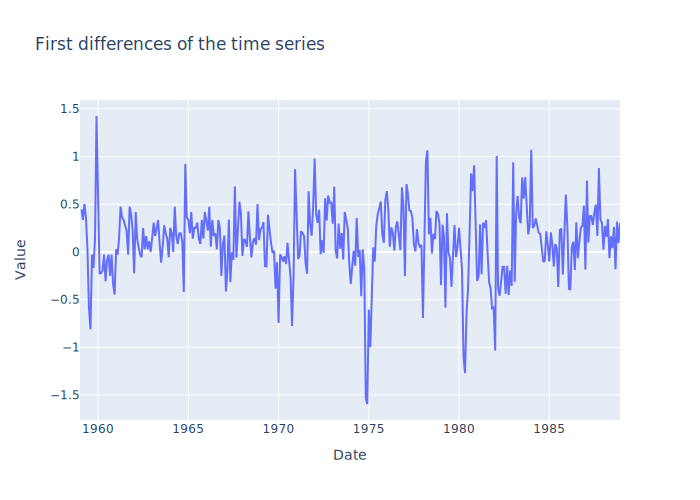

In [32]:
data = pd.read_csv('training.csv')
data.Value = data.Value.diff()
fig = px.line(data, x="Date", y="Value", render_mode="svg", title = 'First differences of the time series')
fig.show()

In [20]:
ts = pd.Series(np.asarray(data['Value'], dtype=np.float64), index=data['Date'])
ts.dropna(inplace=True)

In [21]:
dfTest(ts)

Значение статистики теста Дики-Фуллера:  -7.367311495211981
p-значение:  9.164149561098284e-11
Критические значения:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459}
Единичных корней нет, ряд стационарен


True

#### Отлично, добились стационарности! Так как первые разности ряда оказались стационарны, то наш ряд интегрированный первого порядка. Тогда параметр d модели ARIMA равен 1, найдем p и q, воспользовавшись функциями автокорреляции (для поиска p) и частичной автокорреляции(для поиска q).

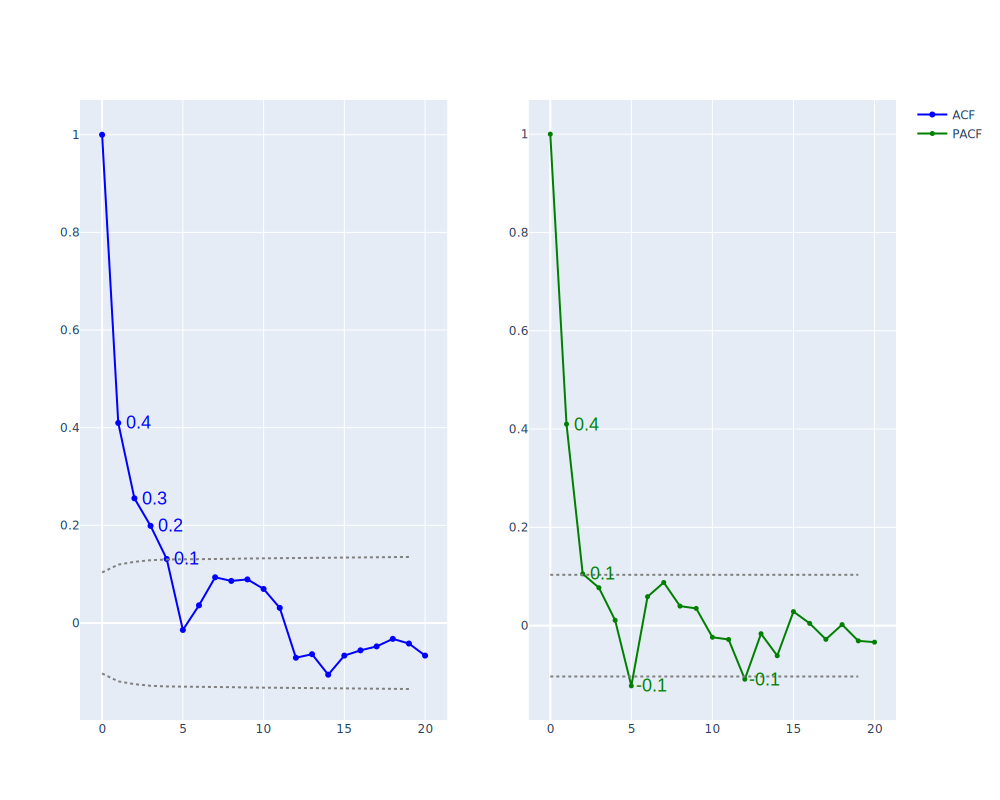

In [22]:
from statsmodels.tsa.stattools import acf, pacf
from plotly.subplots import make_subplots

lag_acf, acf_confint = acf(ts, nlags=20, alpha = 0.05)
acf_lower_bound = acf_confint[1:, 0] - lag_acf[1:]
acf_upper_bound = acf_confint[1:, 1] - lag_acf[1:]
lag_pacf, pacf_confint = pacf(ts, nlags=20, method='ols', alpha = 0.05)
pacf_lower_bound = pacf_confint[1:, 0] - lag_pacf[1:]
pacf_upper_bound = pacf_confint[1:, 1] - lag_pacf[1:]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(
        x=[x for x in range(len(lag_acf))],
        y=lag_acf,
        mode="lines+markers",
        line=go.scatter.Line(color="blue"),
        showlegend=True,
        name = 'ACF'), row = 1, col = 1)

fig.add_trace(go.Scatter(
        x=[x for x in range(len(lag_acf))],
        y=acf_lower_bound,
        mode="lines",
        line=dict(dash='dot', color="gray"),
        showlegend=False), row = 1, col = 1)
fig.add_trace(go.Scatter(
        x=[x for x in range(len(lag_acf))],
        y=acf_upper_bound,
        mode="lines",
        line=dict(dash='dot', color="gray"),
        showlegend=False), row = 1, col = 1)
for i in range(1, len(lag_pacf)):
    if lag_acf[i] > acf_upper_bound[i - 1] or lag_acf[i] < acf_lower_bound[i - 1]:
        fig.add_annotation(x=i, y=lag_acf[i], text=round(lag_acf[i], 1), showarrow=False, font_color = 'blue',
                           font_family = 'Arial', xshift = 20, font_size = 18, row = 1, col = 1)



fig.add_trace(go.Scatter(
        x=[x for x in range(len(lag_acf))],
        y=lag_pacf,
        mode='lines+markers',
        marker=dict(color='green', size=5),
        line=go.scatter.Line(color="green"),
        showlegend=True,
        name = 'PACF'), row = 1, col = 2)
fig.add_trace(go.Scatter(
        x=[x for x in range(len(lag_acf))],
        y=pacf_lower_bound,
        mode="lines",
        line=dict(dash='dot', color="gray"),
        showlegend=False), row = 1, col = 2)
fig.add_trace(go.Scatter(
        x=[x for x in range(len(lag_acf))],
        y=pacf_upper_bound,
        mode="lines",
        line=dict(dash='dot', color="gray"),
        showlegend=False), row = 1, col = 2)

for i in range(1, len(lag_pacf)):
    if lag_pacf[i] > pacf_upper_bound[i - 1] or lag_pacf[i] < pacf_lower_bound[i - 1]:
        fig.add_annotation(x=i, y=lag_pacf[i], text=round(lag_pacf[i], 1), showarrow=False, font_color = 'green',
                           font_family = 'Arial', xshift = 20, font_size = 18, row = 1, col = 2)


fig.update_layout(
    autosize=False,
    width=1000,
    height=800
)
fig.show()

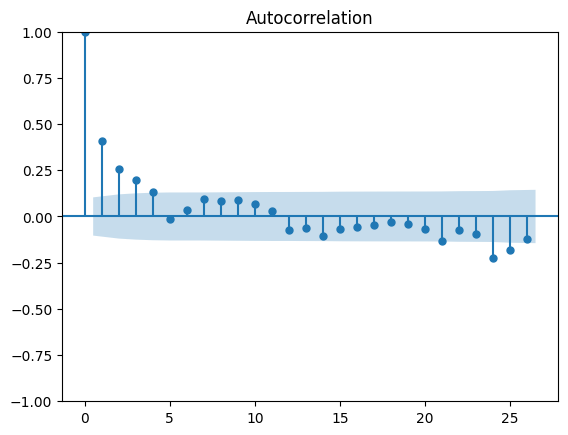

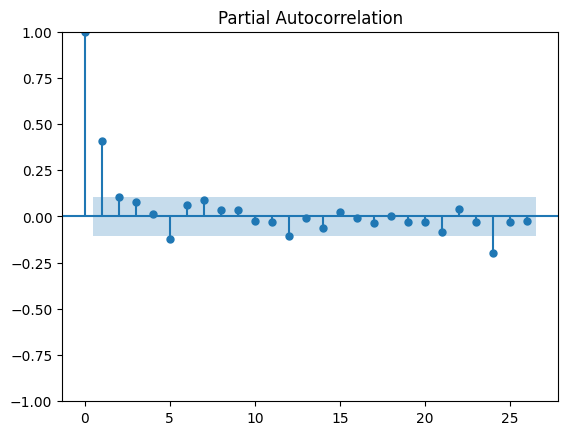

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(ts)
pcf_plot = plot_pacf(ts)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -172.466
Date:                Sun, 03 Dec 2023   AIC                            346.932
Time:                        20:45:23   BIC                            350.816
Sample:                    01-01-1959   HQIC                           348.477
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1530      0.008     18.350      0.000       0.137       0.169
Ljung-Box (L1) (Q):                  60.77   Jarque-Bera (JB):               158.74
Prob(Q):                              0.00   Pr

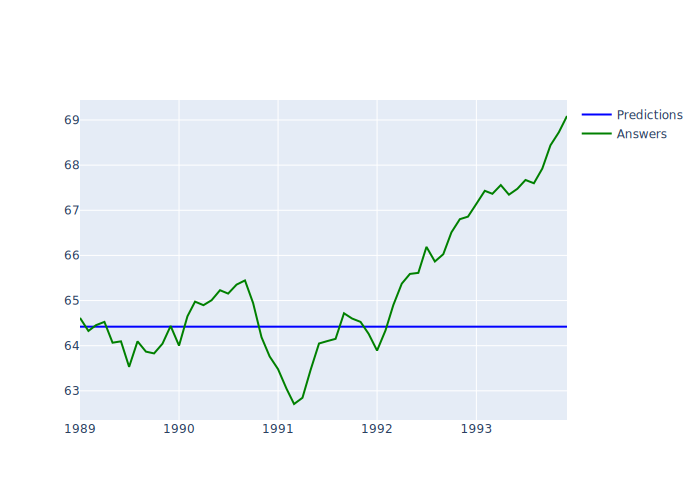

R2_score for p = 0 and q = 0::  -0.28601837404002795
AIC for p = 0 and q = 0: 346.93244595799104
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -141.500
Date:                Sun, 03 Dec 2023   AIC                            287.000
Time:                        20:45:24   BIC                            294.767
Sample:                    01-01-1959   HQIC                           290.089
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3580      0.038      9.430      0.000       0.284       0.432
sigma2         0.1287      0.007  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



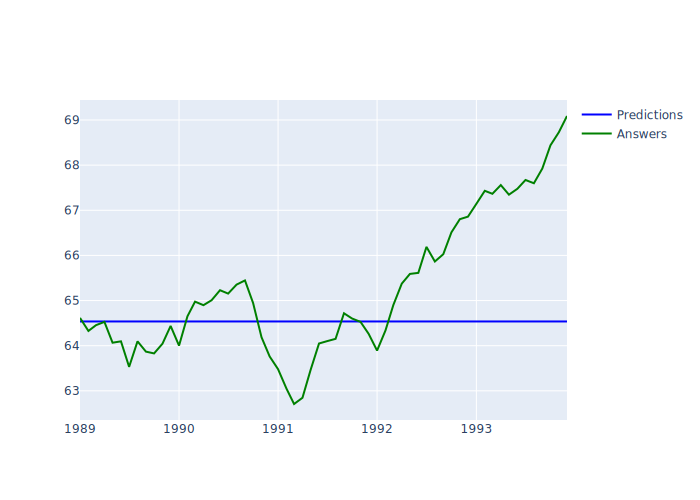

R2_score for p = 0 and q = 1::  -0.21200801704158878
AIC for p = 0 and q = 1: 287.00022267773306
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -134.177
Date:                Sun, 03 Dec 2023   AIC                            274.354
Time:                        20:45:25   BIC                            286.004
Sample:                    01-01-1959   HQIC                           278.987
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3972      0.040      9.949      0.000       0.319       0.475
ma.L2          0.1691      0.053  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



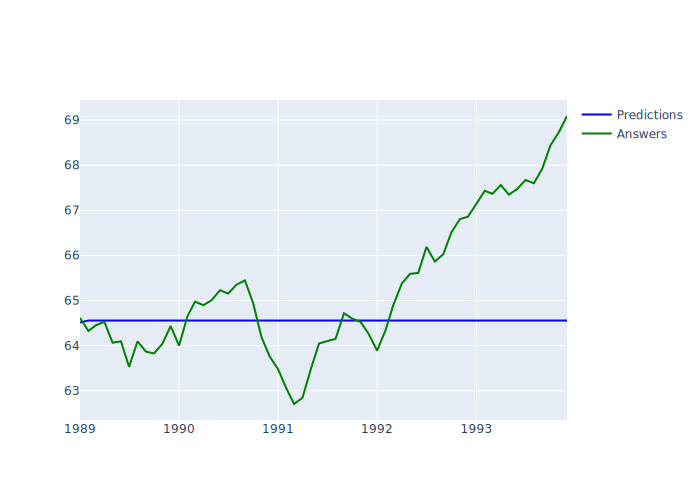

R2_score for p = 0 and q = 2::  -0.2004396645795936
AIC for p = 0 and q = 2: 274.35380252239156
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -129.485
Date:                Sun, 03 Dec 2023   AIC                            266.970
Time:                        20:45:26   BIC                            282.504
Sample:                    01-01-1959   HQIC                           273.147
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3510      0.039      8.965      0.000       0.274       0.428
ma.L2          0.2171      0.052   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



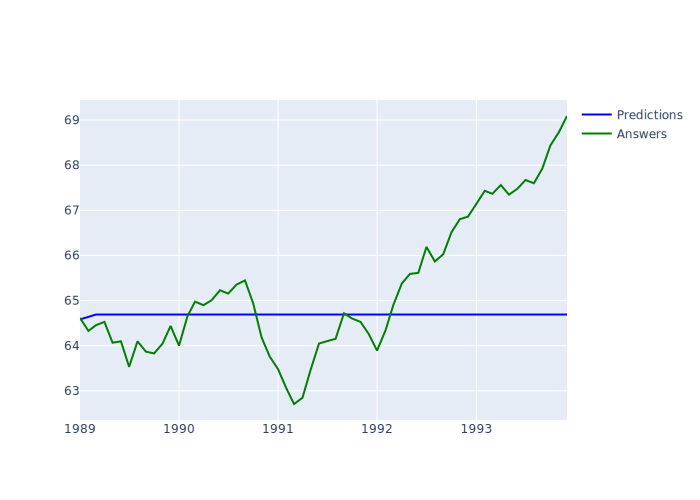

R2_score for p = 0 and q = 3::  -0.1304969226582262
AIC for p = 0 and q = 3: 266.97039766835746
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -121.670
Date:                Sun, 03 Dec 2023   AIC                            253.340
Time:                        20:45:27   BIC                            272.757
Sample:                    01-01-1959   HQIC                           261.061
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3938      0.039     10.168      0.000       0.318       0.470
ma.L2          0.2664      0.054   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



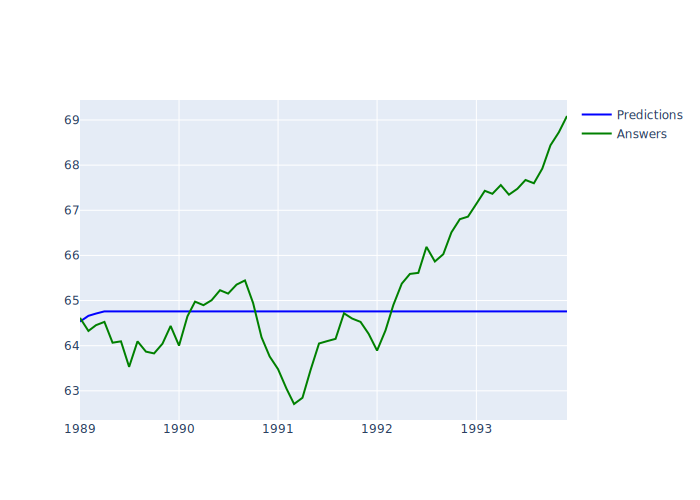

R2_score for p = 0 and q = 4::  -0.09950875173689222
AIC for p = 0 and q = 4: 253.33995408747504
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -129.621
Date:                Sun, 03 Dec 2023   AIC                            263.241
Time:                        20:45:28   BIC                            271.008
Sample:                    01-01-1959   HQIC                           266.330
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4613      0.038     12.257      0.000       0.388       0.535
sigma2         0.1205      0.006  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



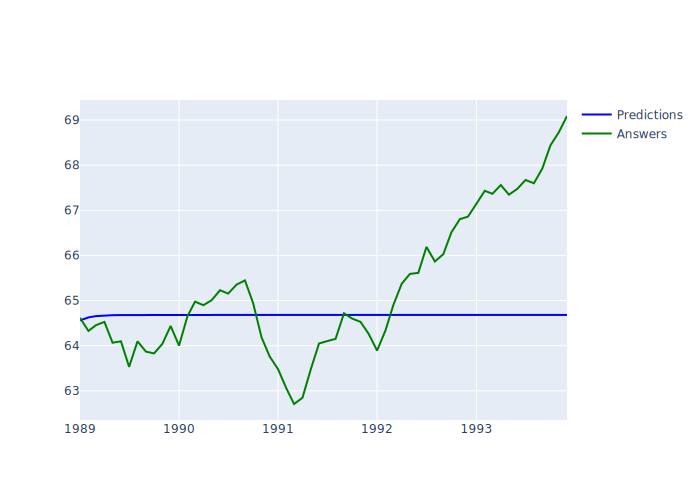

R2_score for p = 1 and q = 0::  -0.13471655543502004
AIC for p = 1 and q = 0: 263.2410498665285


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -124.821
Date:                Sun, 03 Dec 2023   AIC                            255.641
Time:                        20:45:29   BIC                            267.291
Sample:                    01-01-1959   HQIC                           260.274
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7401      0.065     11.465      0.000       0.614       0.867
ma.L1         -0.3684      0.080     -4.599      0.000      -0.525      -0.211
sigma2         0.1173      0.006     20.413      0.0

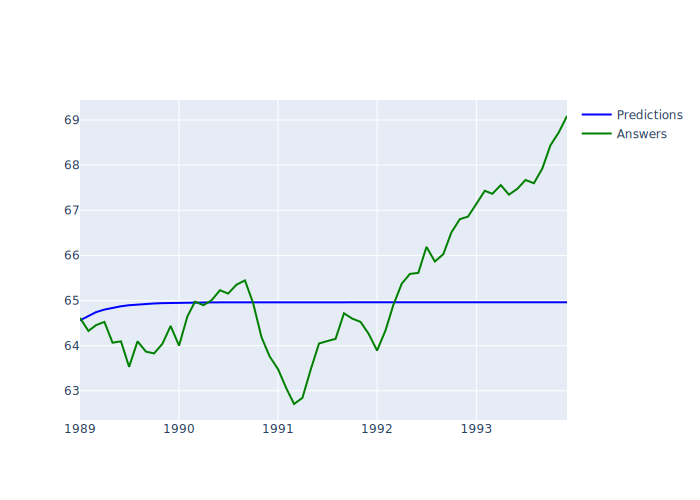

R2_score for p = 1 and q = 1::  -0.02445374937970013
AIC for p = 1 and q = 1: 255.6413548824527
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -124.479
Date:                Sun, 03 Dec 2023   AIC                            256.959
Time:                        20:45:30   BIC                            272.492
Sample:                    01-01-1959   HQIC                           263.136
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8076      0.082      9.848      0.000       0.647       0.968
ma.L1         -0.4253      0.087   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



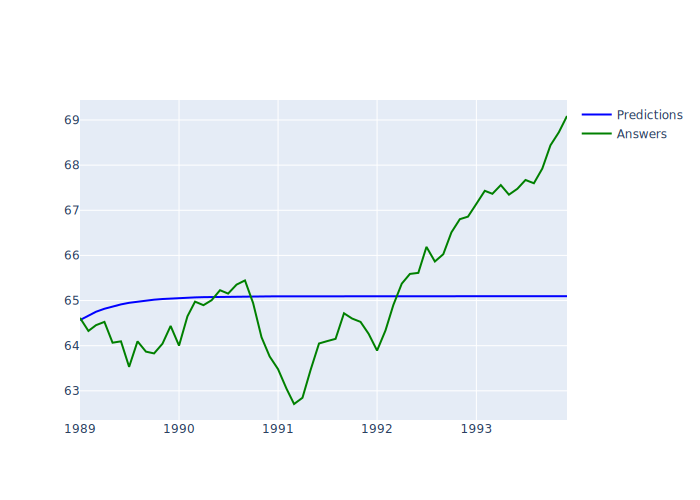

R2_score for p = 1 and q = 2::  0.013704375147949754
AIC for p = 1 and q = 2: 256.95869926549256
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -124.463
Date:                Sun, 03 Dec 2023   AIC                            258.926
Time:                        20:45:31   BIC                            278.343
Sample:                    01-01-1959   HQIC                           266.647
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6250      0.140      4.458      0.000       0.350       0.900
ma.L1         -0.2436      0.140  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



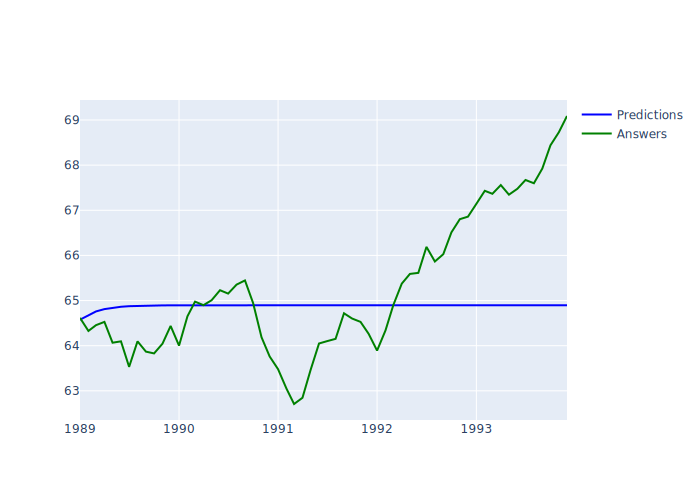

R2_score for p = 1 and q = 3::  -0.04795506879294131
AIC for p = 1 and q = 3: 258.926232048968


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -121.654
Date:                Sun, 03 Dec 2023   AIC                            255.307
Time:                        20:45:32   BIC                            278.607
Sample:                    01-01-1959   HQIC                           264.573
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0446      0.237     -0.188      0.851      -0.509       0.420
ma.L1          0.4364      0.233      1.876      0.061      -0.020       0.892
ma.L2          0.2818      0.097      2.897      0.0

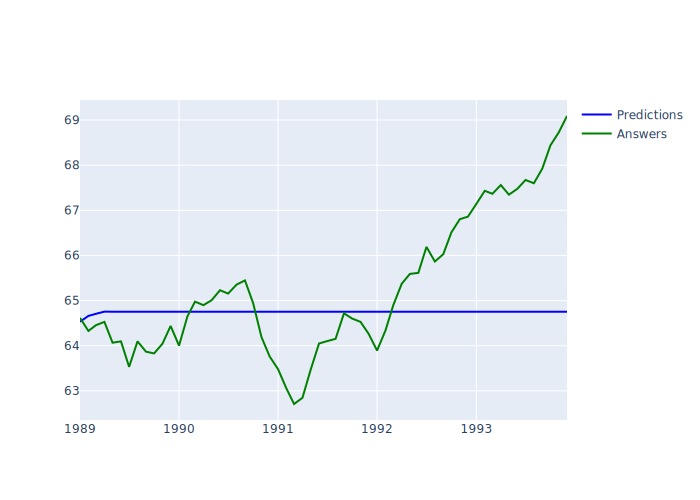

R2_score for p = 1 and q = 4::  -0.10281825587801419
AIC for p = 1 and q = 4: 255.30707724034735
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -126.255
Date:                Sun, 03 Dec 2023   AIC                            258.510
Time:                        20:45:33   BIC                            270.160
Sample:                    01-01-1959   HQIC                           263.143
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3986      0.039     10.115      0.000       0.321       0.476
ar.L2          0.1363      0.046  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



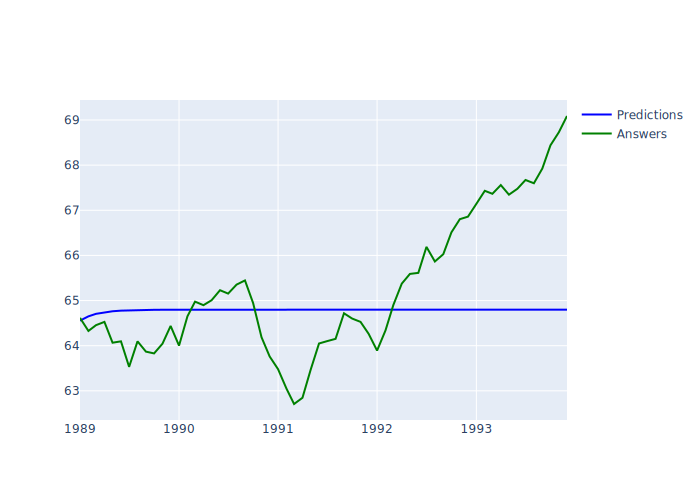

R2_score for p = 2 and q = 0::  -0.08294008386244633
AIC for p = 2 and q = 0: 258.51002093534254
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -124.427
Date:                Sun, 03 Dec 2023   AIC                            256.855
Time:                        20:45:34   BIC                            272.388
Sample:                    01-01-1959   HQIC                           263.032
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0592      0.186      5.688      0.000       0.694       1.424
ar.L2         -0.1766      0.107  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



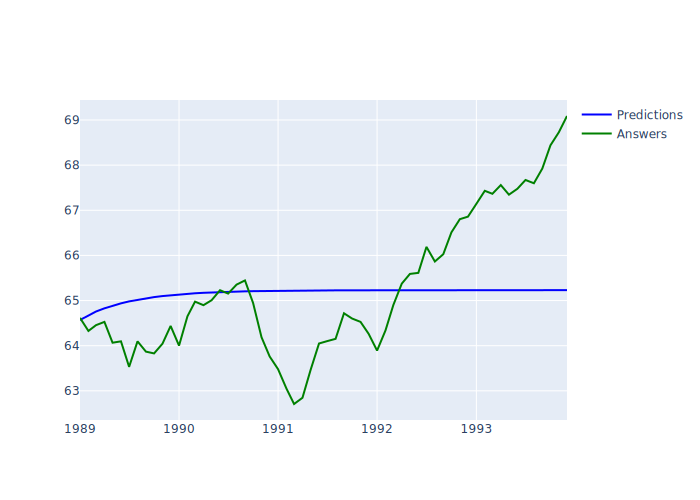

R2_score for p = 2 and q = 1::  0.04478485716828695
AIC for p = 2 and q = 1: 256.8545848374372


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -124.478
Date:                Sun, 03 Dec 2023   AIC                            258.957
Time:                        20:45:35   BIC                            278.373
Sample:                    01-01-1959   HQIC                           266.678
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7043      1.108      0.636      0.525      -1.467       2.875
ar.L2          0.0731      0.826      0.089      0.929      -1.545       1.691
ma.L1         -0.3219      1.102     -0.292      0.7

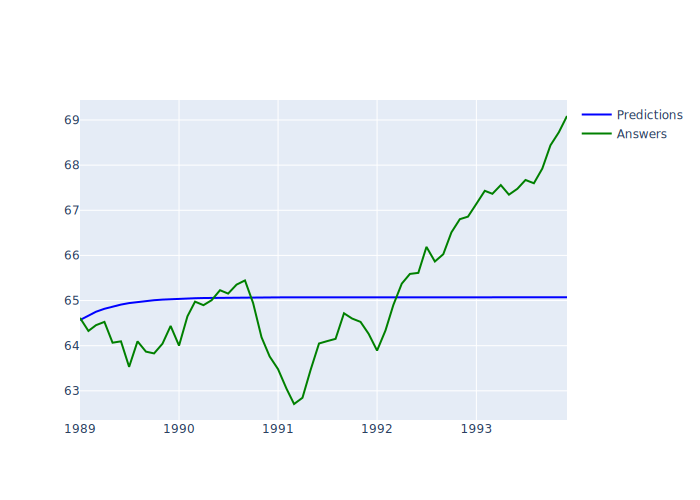

R2_score for p = 2 and q = 2::  0.007256367609377423
AIC for p = 2 and q = 2: 258.9566852999098


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -124.165
Date:                Sun, 03 Dec 2023   AIC                            260.329
Time:                        20:45:36   BIC                            283.629
Sample:                    01-01-1959   HQIC                           269.595
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8085      0.411      1.967      0.049       0.003       1.614
ar.L2         -0.2971      0.301     -0.987      0.324      -0.887       0.293
ma.L1         -0.4299      0.414     -1.038      0.2

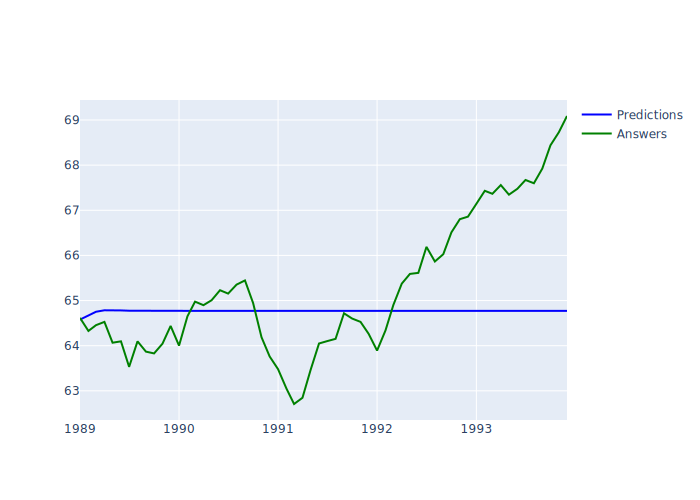

R2_score for p = 2 and q = 3::  -0.09512684989442866
AIC for p = 2 and q = 3: 260.32938235142035


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -121.650
Date:                Sun, 03 Dec 2023   AIC                            257.301
Time:                        20:45:38   BIC                            284.484
Sample:                    01-01-1959   HQIC                           268.111
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0320      0.299     -0.107      0.915      -0.618       0.554
ar.L2         -0.0194      0.264     -0.074      0.941      -0.536       0.497
ma.L1          0.4237      0.293      1.445      0.1

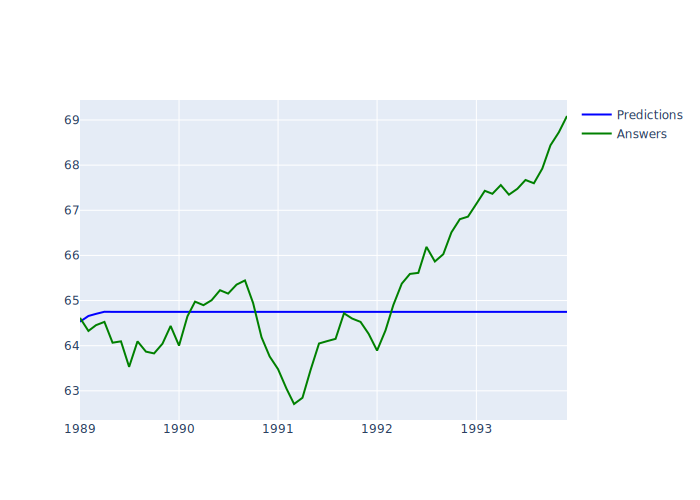

R2_score for p = 2 and q = 4::  -0.10445753894719179
AIC for p = 2 and q = 4: 257.3009580024832
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -124.387
Date:                Sun, 03 Dec 2023   AIC                            256.774
Time:                        20:45:39   BIC                            272.307
Sample:                    01-01-1959   HQIC                           262.951
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3849      0.039      9.913      0.000       0.309       0.461
ar.L2          0.0959      0.053   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



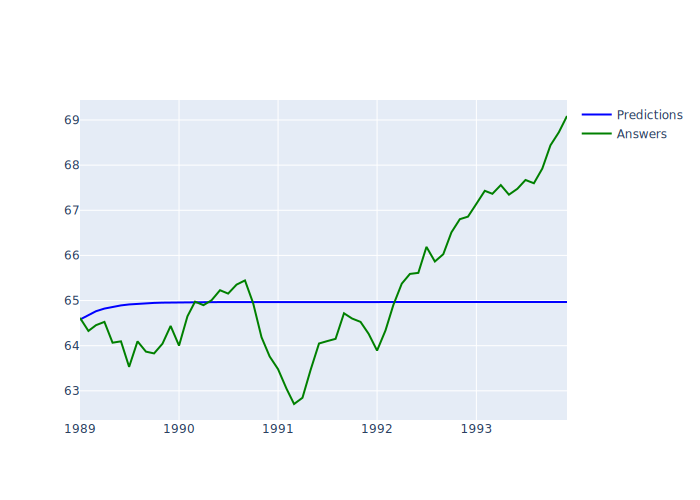

R2_score for p = 3 and q = 0::  -0.02425659755609555
AIC for p = 3 and q = 0: 256.77377446379046


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -124.312
Date:                Sun, 03 Dec 2023   AIC                            258.623
Time:                        20:45:39   BIC                            278.040
Sample:                    01-01-1959   HQIC                           266.345
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5119      0.478      1.072      0.284      -0.424       1.448
ar.L2          0.0448      0.193      0.232      0.816      -0.333       0.423
ar.L3          0.0856      0.092      0.930      0.3

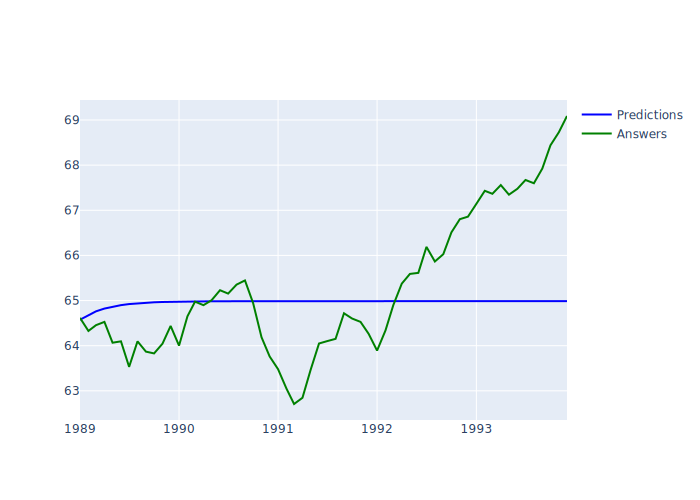

R2_score for p = 3 and q = 1::  -0.018268916123741263
AIC for p = 3 and q = 1: 258.6234768768383


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -122.668
Date:                Sun, 03 Dec 2023   AIC                            257.335
Time:                        20:45:41   BIC                            280.635
Sample:                    01-01-1959   HQIC                           266.601
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6853      0.316      2.171      0.030       0.067       1.304
ar.L2         -0.5553      0.329     -1.688      0.091      -1.200       0.089
ar.L3          0.3185      0.110      2.908      0.0

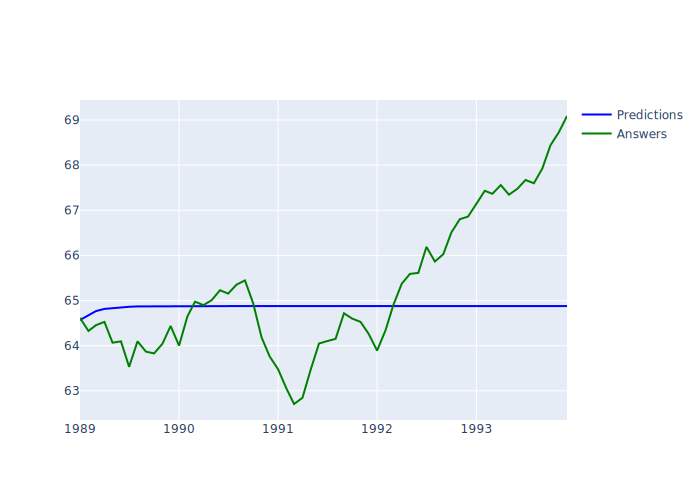

R2_score for p = 3 and q = 2::  -0.05404253235609913
AIC for p = 3 and q = 2: 257.33545708372424


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -121.503
Date:                Sun, 03 Dec 2023   AIC                            257.006
Time:                        20:45:42   BIC                            284.190
Sample:                    01-01-1959   HQIC                           267.816
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0172      0.091      0.190      0.849      -0.160       0.195
ar.L2         -0.3797      0.086     -4.401      0.000      -0.549      -0.211
ar.L3          0.7062      0.066     10.648      0.0

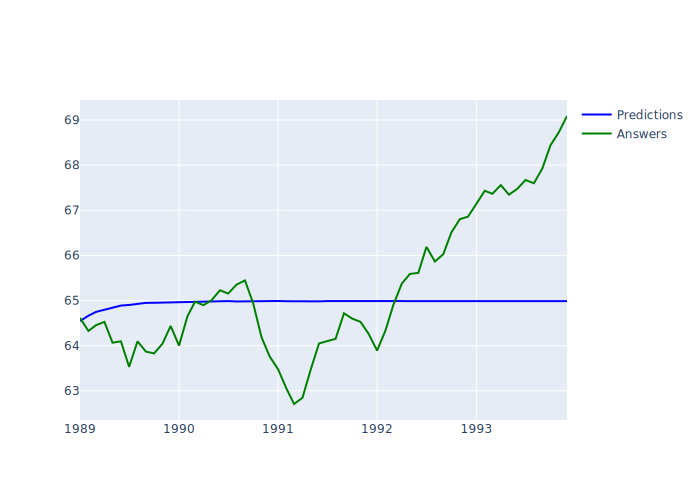

R2_score for p = 3 and q = 3::  -0.01692081614002028
AIC for p = 3 and q = 3: 257.0063378599536


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -121.388
Date:                Sun, 03 Dec 2023   AIC                            258.776
Time:                        20:45:44   BIC                            289.843
Sample:                    01-01-1959   HQIC                           271.130
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0540      0.322      0.168      0.867      -0.577       0.685
ar.L2         -0.2904      0.286     -1.017      0.309      -0.850       0.269
ar.L3          0.2845      0.249      1.142      0.2

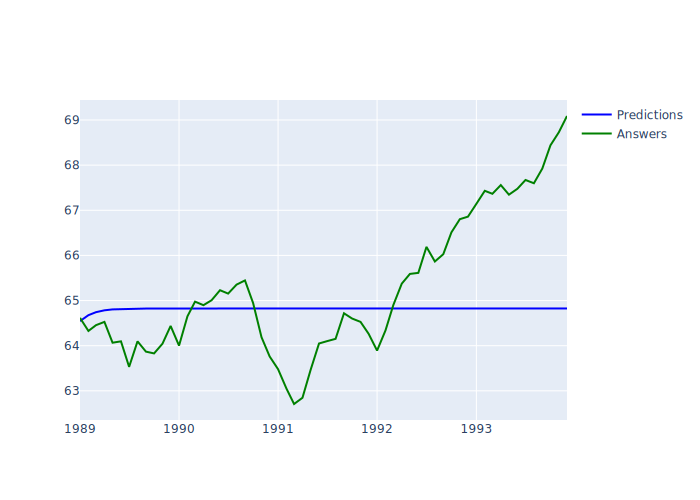

R2_score for p = 3 and q = 4::  -0.07369786650082233
AIC for p = 3 and q = 4: 258.7760684290494


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -124.186
Date:                Sun, 03 Dec 2023   AIC                            258.372
Time:                        20:45:45   BIC                            277.788
Sample:                    01-01-1959   HQIC                           266.093
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3815      0.039      9.790      0.000       0.305       0.458
ar.L2          0.0929      0.054      1.716      0.086      -0.013       0.199
ar.L3          0.0889      0.058      1.544      0.1

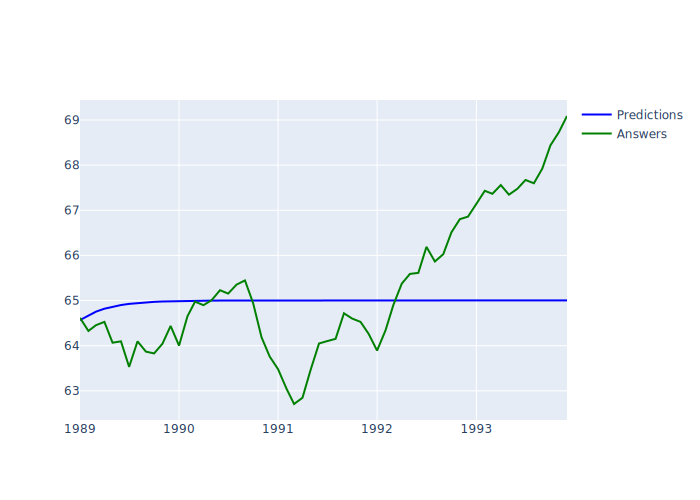

R2_score for p = 4 and q = 0::  -0.013217168596242113
AIC for p = 4 and q = 0: 258.3717248704518
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -123.224
Date:                Sun, 03 Dec 2023   AIC                            258.448
Time:                        20:45:46   BIC                            281.748
Sample:                    01-01-1959   HQIC                           267.714
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1924      0.484     -0.397      0.691      -1.141       0.756
ar.L2          0.3095      0.187  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



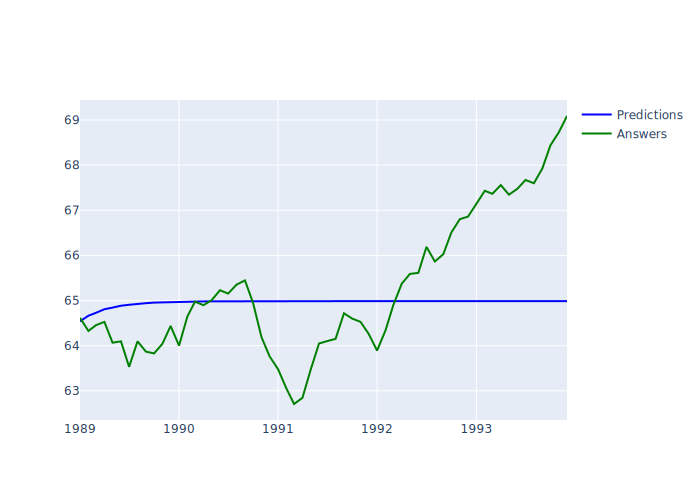

R2_score for p = 4 and q = 1::  -0.016858994392711768
AIC for p = 4 and q = 1: 258.4480810456313


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -121.538
Date:                Sun, 03 Dec 2023   AIC                            257.075
Time:                        20:45:47   BIC                            284.258
Sample:                    01-01-1959   HQIC                           267.885
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2487      0.269     -0.926      0.354      -0.775       0.278
ar.L2         -0.2639      0.221     -1.193      0.233      -0.697       0.169
ar.L3          0.3885      0.098      3.945      0.0

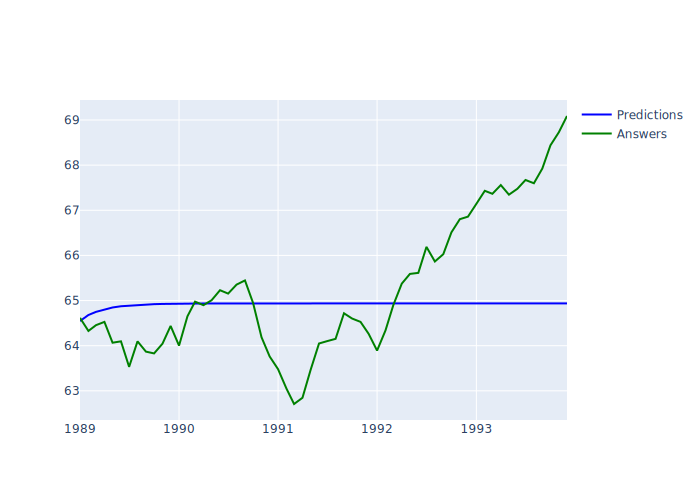

R2_score for p = 4 and q = 2::  -0.03350101343950018
AIC for p = 4 and q = 2: 257.0750369030164


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -121.245
Date:                Sun, 03 Dec 2023   AIC                            258.490
Time:                        20:45:48   BIC                            289.556
Sample:                    01-01-1959   HQIC                           270.844
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2906      0.358     -0.812      0.417      -0.992       0.411
ar.L2         -0.2100      0.259     -0.812      0.417      -0.717       0.297
ar.L3          0.1397      0.270      0.518      0.6

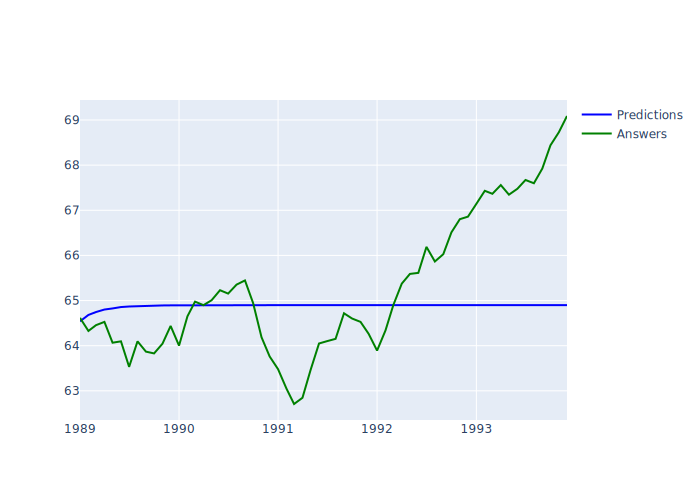

R2_score for p = 4 and q = 3::  -0.04658351134662597
AIC for p = 4 and q = 3: 258.48985090574405


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -121.183
Date:                Sun, 03 Dec 2023   AIC                            260.367
Time:                        20:45:50   BIC                            295.316
Sample:                    01-01-1959   HQIC                           274.265
                         - 12-01-1988                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2936      0.390      3.318      0.001       0.529       2.058
ar.L2         -1.1781      0.298     -3.957      0.000      -1.762      -0.595
ar.L3          1.2125      0.374      3.240      0.0

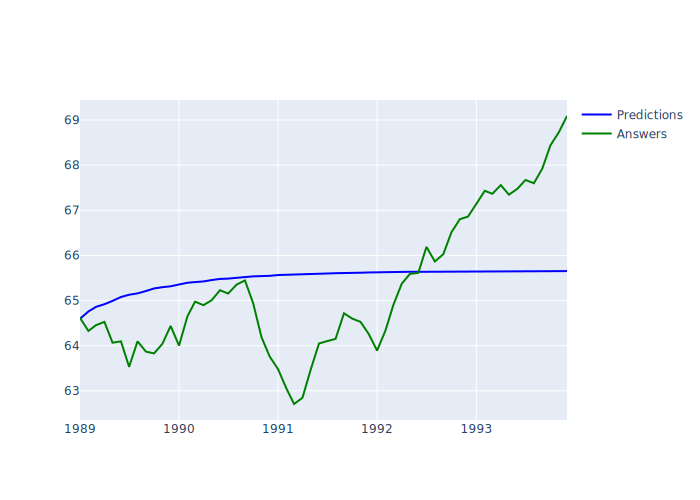

R2_score for p = 4 and q = 4::  0.08348308375212687
AIC for p = 4 and q = 4: 260.3665415432456


In [28]:
aics = []
for p in range(5):
    for q in range(5):
        data = pd.read_csv("training.csv")
        data.index = data.Date
        data = data.Value
        model = smapi.tsa.ARIMA(data, order=(p, 1, q), freq='MS')
        model = model.fit()
        print(model.summary())

        predictions = []
        test = pd.read_csv("testing.csv").sort_values('Date')
        for i in range(len(test['Date'])):
            predictions.append(model.predict(pd.to_datetime(test['Date'][i])))
    
        r2 = r2_score(test.Value, predictions)

        predictions_df = {'Date' : [], 'Value' : []}
        for pair in predictions:
            predictions_df['Date'].append(pair.keys()[0])
            predictions_df['Value'].append(pair[0])
        predictions_df = pd.DataFrame(predictions_df)

        fig = go.Figure()
    
        fig.add_trace(go.Scatter(
                x=predictions_df.Date,
                y=predictions_df.Value,
                mode="lines",
                line=go.scatter.Line(color="blue"),
                showlegend=True,
                name = 'Predictions'))

        fig.add_trace(go.Scatter(
                x=test.Date,
                y=test.Value,
                mode="lines",
                line=go.scatter.Line(color="green"),
                showlegend=True,
                name = 'Answers'))

        fig.show()
        print(f"R2_score for p = {p} and q = {q}:: ", r2)
        print(f"AIC for p = {p} and q = {q}:", model.aic)
        aics.append({f"{p}, {q}" : model.aic})

In [29]:
aics

[{'0, 0': 346.93244595799104},
 {'0, 1': 287.00022267773306},
 {'0, 2': 274.35380252239156},
 {'0, 3': 266.97039766835746},
 {'0, 4': 253.33995408747504},
 {'1, 0': 263.2410498665285},
 {'1, 1': 255.6413548824527},
 {'1, 2': 256.95869926549256},
 {'1, 3': 258.926232048968},
 {'1, 4': 255.30707724034735},
 {'2, 0': 258.51002093534254},
 {'2, 1': 256.8545848374372},
 {'2, 2': 258.9566852999098},
 {'2, 3': 260.32938235142035},
 {'2, 4': 257.3009580024832},
 {'3, 0': 256.77377446379046},
 {'3, 1': 258.6234768768383},
 {'3, 2': 257.33545708372424},
 {'3, 3': 257.0063378599536},
 {'3, 4': 258.7760684290494},
 {'4, 0': 258.3717248704518},
 {'4, 1': 258.4480810456313},
 {'4, 2': 257.0750369030164},
 {'4, 3': 258.48985090574405},
 {'4, 4': 260.3665415432456}]

### По критерию Акаике наилучшей моделью является модель с параметрами p = 0, q = 4, d = 1